In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df_original = pd.read_csv("../data/interm/cleaned_df.csv")
df = df_original.copy()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11083 entries, 0 to 11082
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    11083 non-null  int64  
 1   title                 11083 non-null  object 
 2   vote_average          11083 non-null  float64
 3   vote_count            11083 non-null  int64  
 4   release_date          10832 non-null  object 
 5   revenue               11083 non-null  int64  
 6   runtime               11083 non-null  int64  
 7   adult                 11083 non-null  bool   
 8   budget                11083 non-null  int64  
 9   original_language     11083 non-null  object 
 10  overview              10655 non-null  object 
 11  popularity            11083 non-null  float64
 12  genres                10845 non-null  object 
 13  production_companies  10264 non-null  object 
 14  production_countries  10390 non-null  object 
dtypes: bool(1), float64

## Vote average

count    11083.000000
mean         6.675401
std          1.395366
min          0.800000
25%          5.900500
50%          6.554000
75%          7.244000
max         10.000000
Name: vote_average, dtype: float64

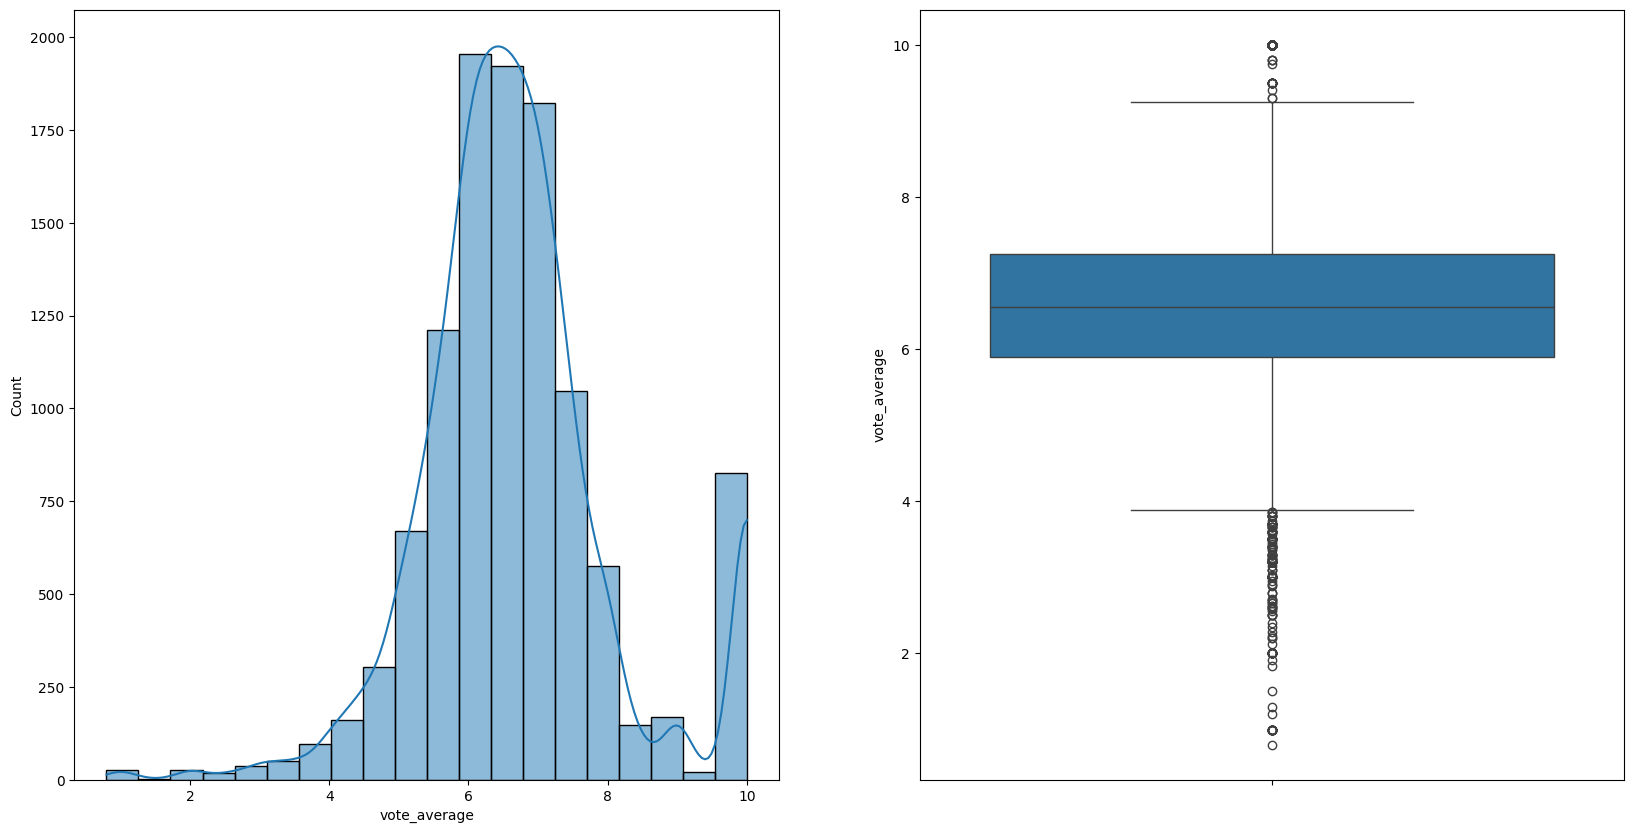

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(
    data=df["vote_average"],
    bins=20,
    kde=True,
    ax=axes[0]
)

sns.boxplot(
    data=df["vote_average"]
)

df["vote_average"].describe()

count    11083.000000
mean      1379.962194
std       2865.529875
min          1.000000
25%         26.000000
50%        295.000000
75%       1356.000000
max      34495.000000
Name: vote_count, dtype: float64

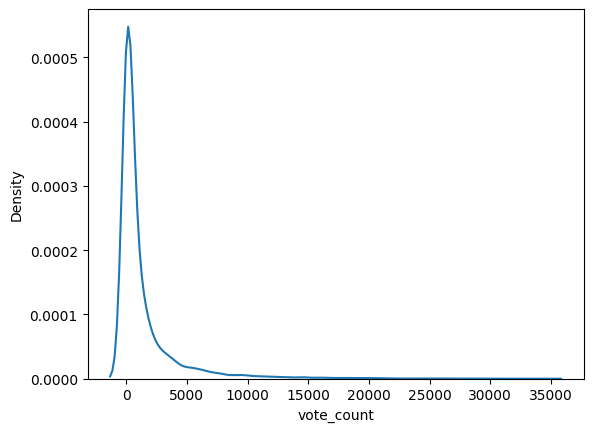

In [77]:
sns.kdeplot(
    data=df["vote_count"],
)
df["vote_count"].describe()

La variable voute_count se encuentra muy sesgada a la derecha. Muchas peliculas tienen pocos votos mientras que pocas peliculas tienen mucho votos. Para analisis que asuman normalidad se puede considerar usar el log en vez de el valor crudo.

<Axes: xlabel='revenue', ylabel='Count'>

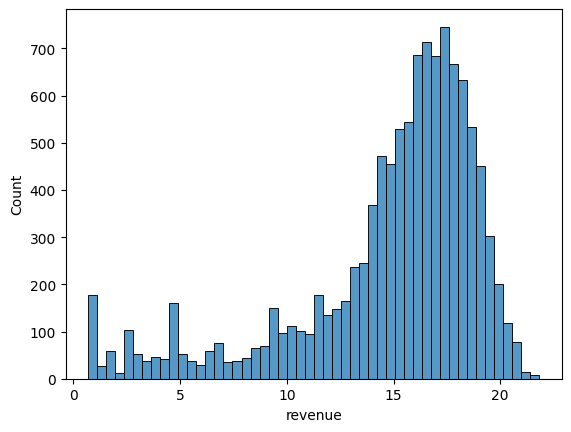

In [78]:
revenue_prueba = valid_revenue["revenue"]

sns.histplot(
    data = np.log1p(revenue_prueba),
    bins = 50
)

<Axes: xlabel='budget', ylabel='Count'>

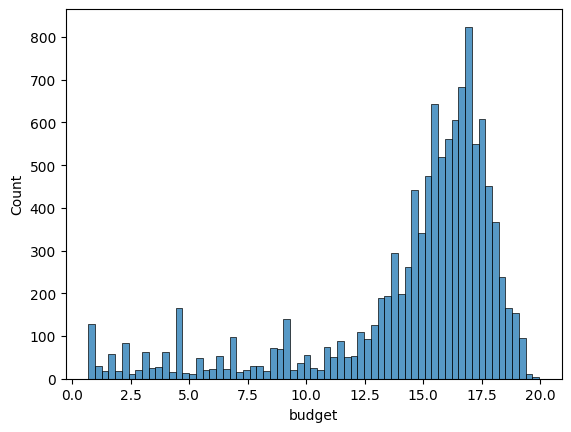

In [68]:
sns.histplot(
    data=np.log1p(valid_revenue["budget"])
)

Tanto budget como revenue tienen están muy sesgados. Viéndolo de manera logaritmica, podemos encontrar que hay pocas peliculas con ingresos y gastos elevados, lo mismo sucede con ingresos y gastos altos. 

count    11083.000000
mean        99.646756
std         42.547834
min          0.000000
25%         90.000000
50%        102.000000
75%        118.000000
max        999.000000
Name: runtime, dtype: float64

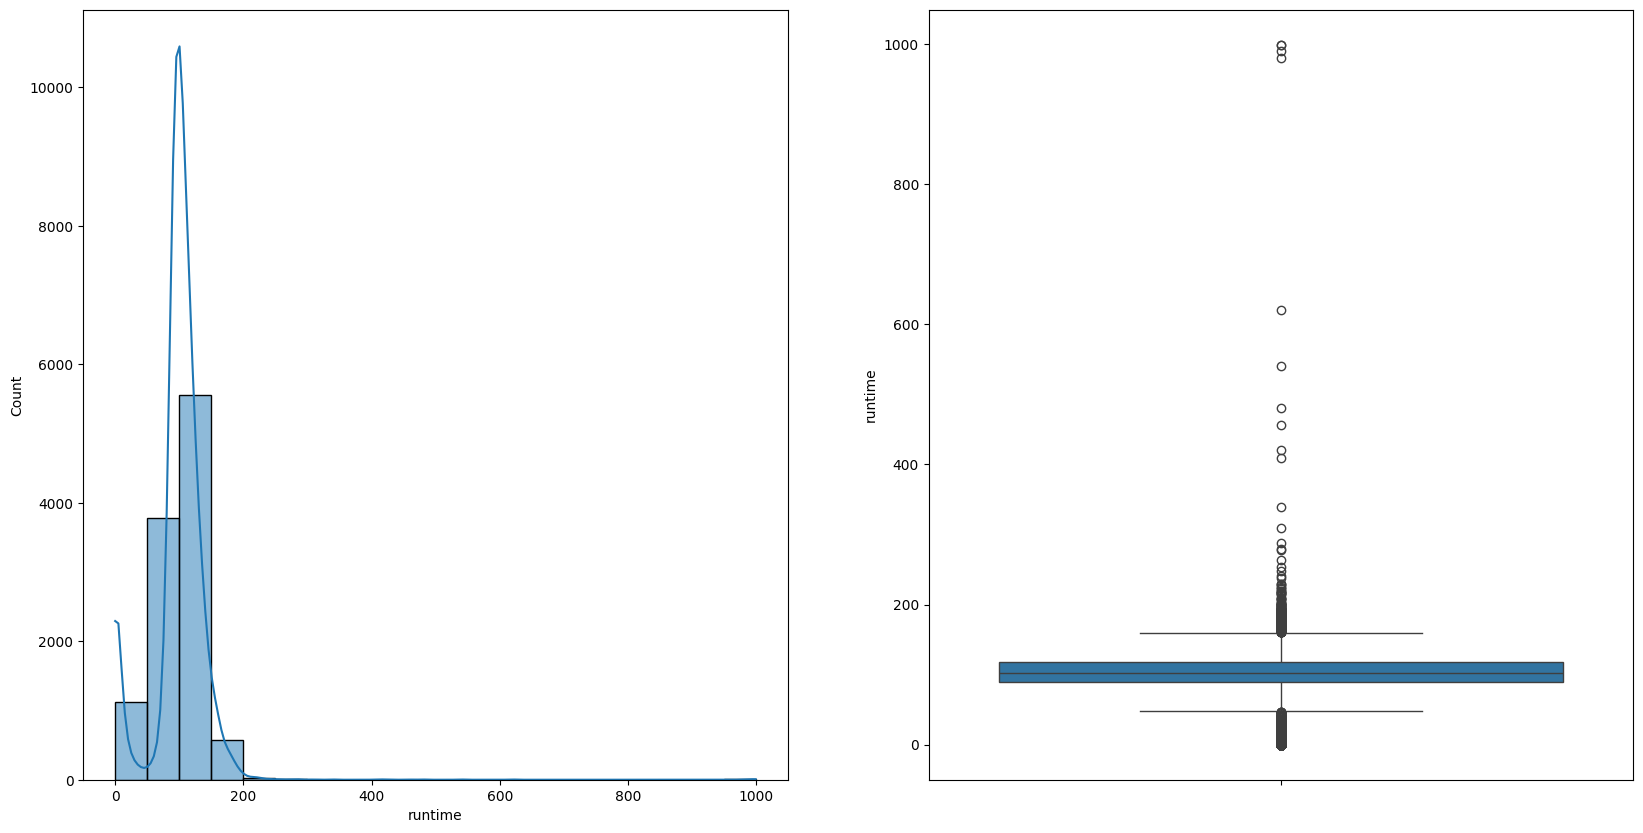

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(
    data=df["runtime"],
    bins=20,
    kde=True,
    ax=axes[0]
)

sns.boxplot(
    data=df["runtime"]
)

df["runtime"].describe()

Vemos que la distribucion esta sesgada a la izquierda. La mayoria de datos se encuentra cerca de la mediana de 42 minutos. Hay varios outliers.

<Axes: xlabel='adult', ylabel='count'>

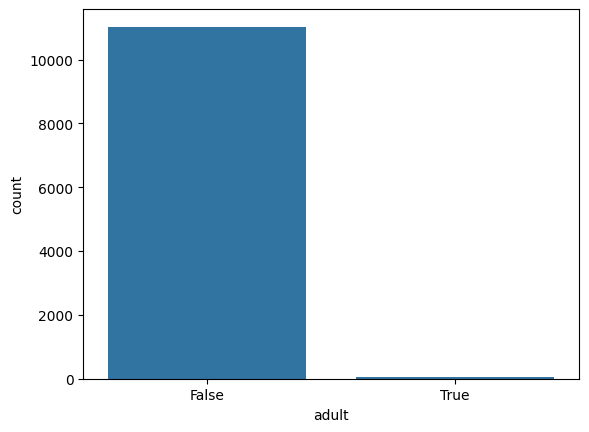

In [ ]:
sns.countplot(x=df["adult"]) # Esta variable está muy sesgada, la podemos eliminar. 

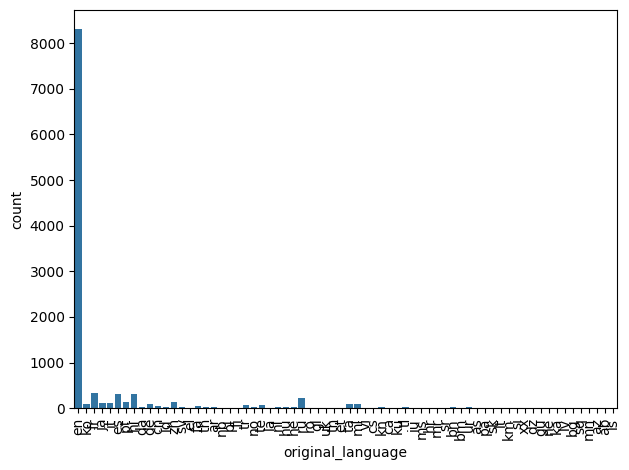

In [9]:
sns.countplot(
    x=df["original_language"]
)
plt.xticks(rotation=90)
plt.tight_layout()

Tambien hay mucho sesgo. Podemos eliminar la feature original_language

Remover la feature overview

count    11083.000000
mean        17.549618
std         58.809448
min          0.000000
25%          3.745500
50%         11.916000
75%         19.425000
max       2994.357000
Name: popularity, dtype: float64

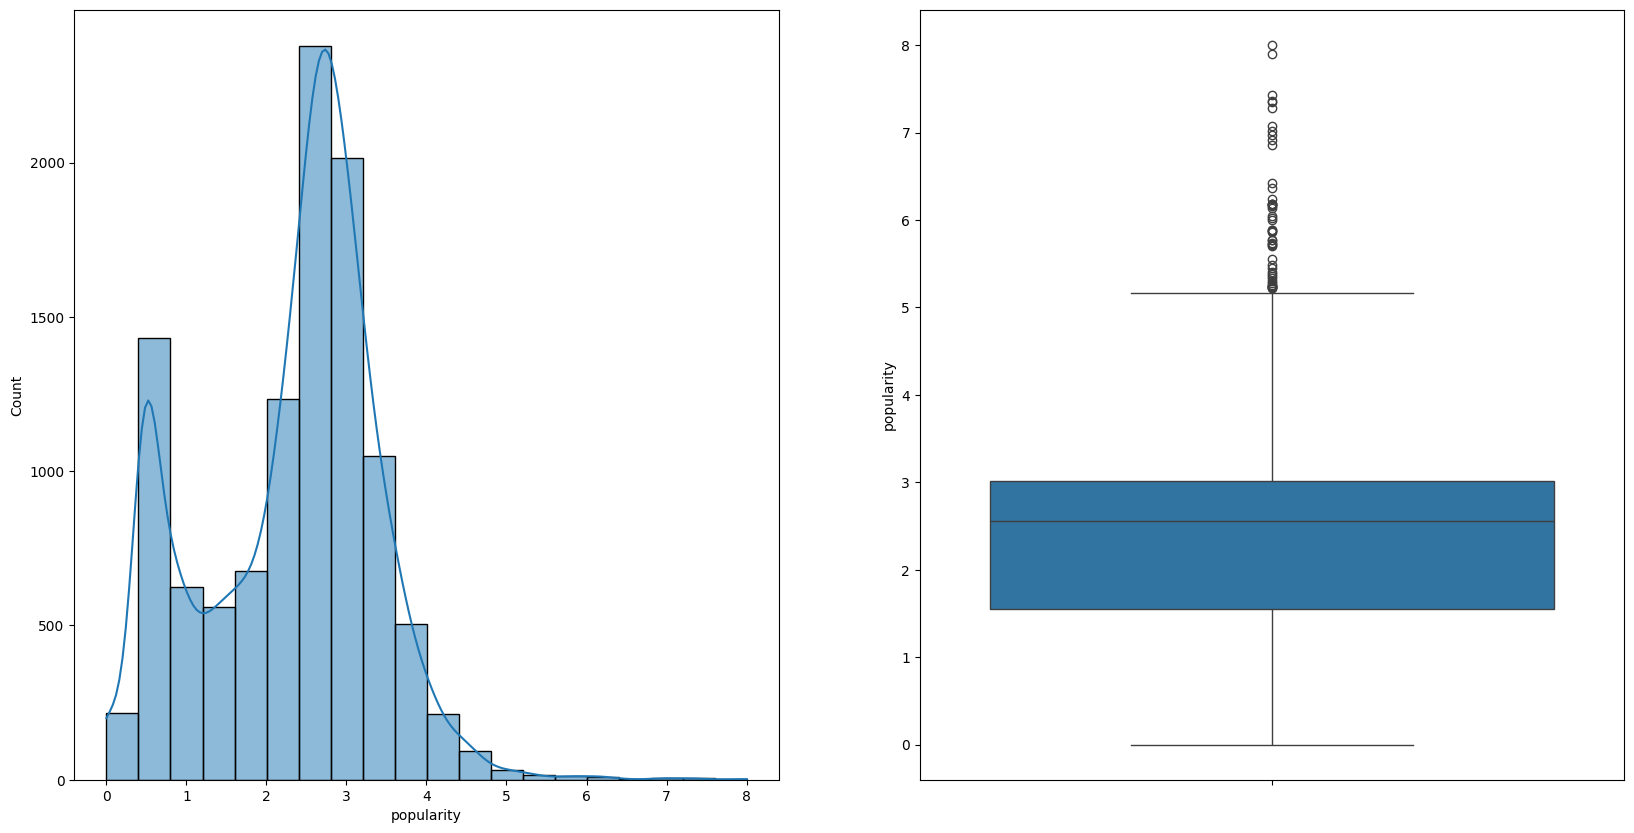

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(
    data=np.log1p(df["popularity"]),
    bins=20,
    kde=True,
    ax=axes[0]
)

sns.boxplot(
    data=np.log1p(df["popularity"])
)

df["popularity"].describe()

In [ ]:
Hay varios outliers. Se puede quedar, depronto hay que normalizarla a la hora de introducirla al modelo.

In [19]:
df["genres_list"] = df['genres'].fillna("ninguno").str.split(", ")


In [34]:
genre_freq = df[["genres_list"]]["genres_list"].explode().value_counts(normalize=True).to_dict()

In [37]:
df['genres_freq_list'] = df["genres_list"].apply(lambda lst: [genre_freq[g] for g in lst])

In [44]:
df['genres_freq_mean'] = df['genres_freq_list'].apply(lambda freqs: np.mean(freqs) if freqs else 0)

count    11083.000000
mean         0.098623
std          0.042737
min          0.001370
25%          0.069527
50%          0.097134
75%          0.129036
max          0.186009
Name: genres_freq_mean, dtype: float64

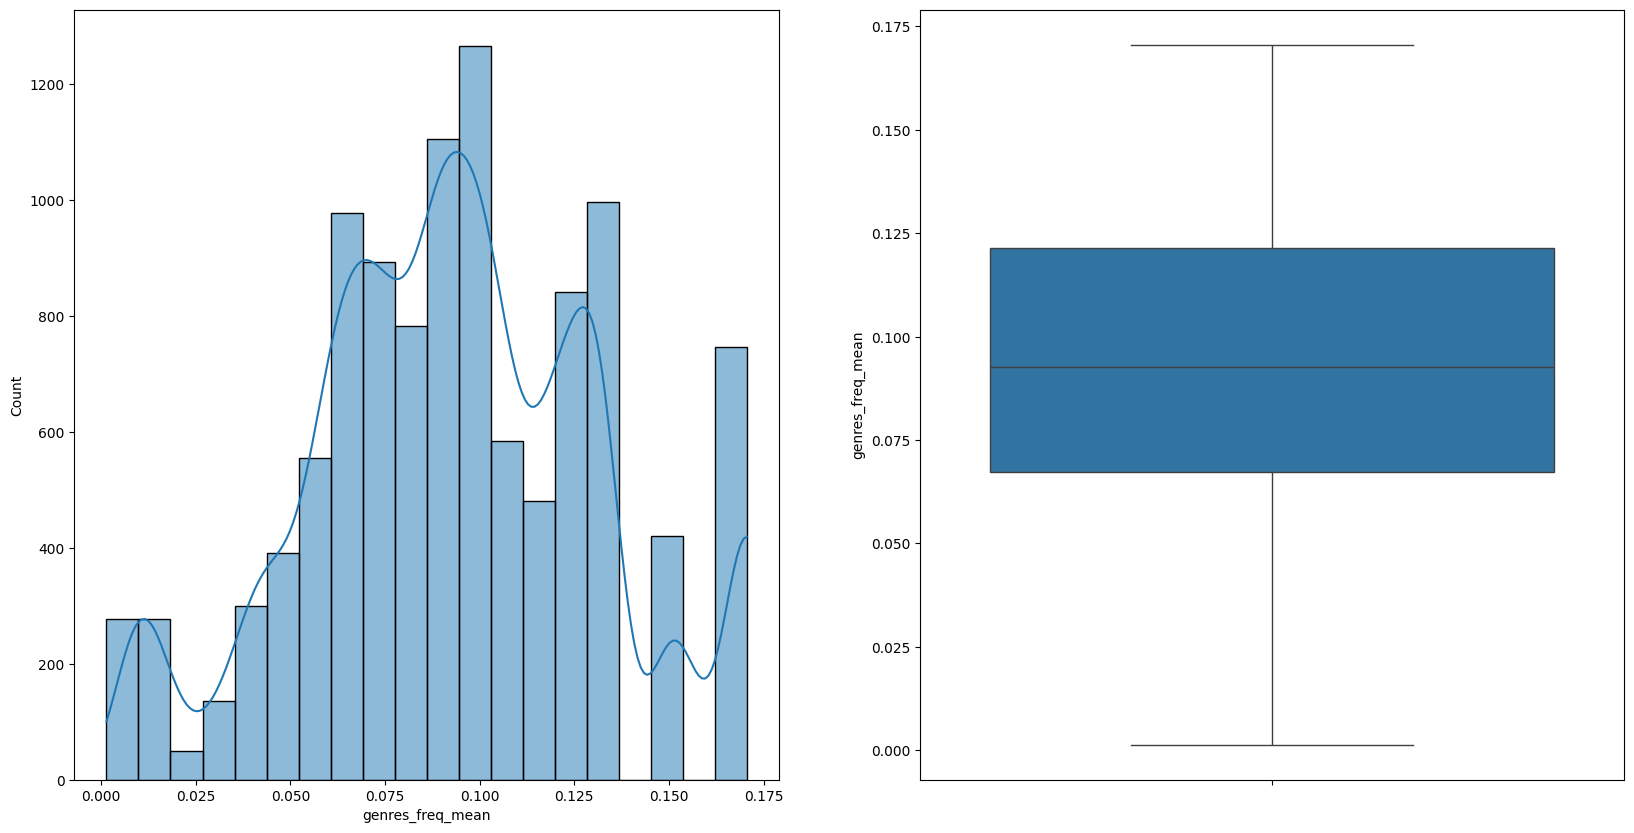

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(
    data=np.log1p(df["genres_freq_mean"]),
    bins=20,
    kde=True,
    ax=axes[0]
)

sns.boxplot(
    data=np.log1p(df["genres_freq_mean"])
)

df["genres_freq_mean"].describe()

In [ ]:
Habria que hacer una funcion para convertir los datos de entrada posteriores a frecuencia.

In [53]:
companies = df["production_companies"].fillna("ninguna").str.split(", ").explode().value_counts()

In [72]:
print(f"Hay {companies.shape[0]} compañias diferente")

Hay 10517 compañias diferente


Debido a la gran cantidad de compañías y que muchas de ellas tienen una sola película, lo mejor sería no tenerla en cuenta.

In [86]:
countries = df["production_countries"].fillna("ninguno").str.split(", ").explode().value_counts().reset_index()

In [94]:
countries[countries["production_countries"] != "United States of America"]["count"].sum()

np.int64(7941)

In [95]:
countries[countries["production_countries"] == "United States of America"]["count"].sum()

np.int64(7133)

In [96]:
df["by_usa"] = np.where(df["production_countries"].str.contains("United States of America"), 1, 0)

In [97]:
df

,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,budget,original_language,overview,popularity,genres,production_companies,production_countries,genres_list,genres_freq_list,genres_freq_mean,by_usa
0,27205,Inception,8.364,34495,2010-07-15,825532764,148,False,160000000,en,"Cobb, a skilled thief who commits corporate es...",83.952,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","[Action, Science Fiction, Adventure]","[0.09572655902829211, 0.03751296104280847, 0.0...",0.065336,1
1,157336,Interstellar,8.417,32571,2014-11-05,701729206,169,False,165000000,en,The adventures of a group of explorers who mak...,140.241,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America","[Adventure, Drama, Science Fiction]","[0.0627684787438898, 0.1860094800770256, 0.037...",0.095430,1
2,155,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,False,185000000,en,Batman raises the stakes in his war on crime. ...,130.643,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","[Drama, Action, Crime, Thriller]","[0.1860094800770256, 0.09572655902829211, 0.05...",0.108012,1
3,19995,Avatar,7.573,29815,2009-12-15,2923706026,162,False,237000000,en,"In the 22nd century, a paraplegic Marine is di...",79.932,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","[Action, Adventure, Fantasy, Science Fiction]","[0.09572655902829211, 0.0627684787438898, 0.03...",0.057816,1
4,24428,The Avengers,7.710,29166,2012-04-25,1518815515,143,False,220000000,en,When an unexpected enemy emerges and threatens...,98.082,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"[Science Fiction, Action, Adventure]","[0.03751296104280847, 0.09572655902829211, 0.0...",0.065336,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11078,69435,Aanai,7.000,1,2005-05-05,500000,157,False,500000,ta,Aanai is a 2005 Tamil language film released i...,4.182,"Action, Drama, Thriller",NaN,India,"[Action, Drama, Thriller]","[0.09572655902829211, 0.1860094800770256, 0.09...",0.124809,0
11079,1452392,Thaai Amma Ashoksaravanan Songs,10.000,1,NaN,197,3,False,174,en,Thaai Amma Release on 22-03-2025 Tamil Song -...,0.900,NaN,NaN,NaN,[ninguno],[0.008813509109761516],0.008814,1
11080,69442,Parasuram,6.000,1,2003-05-05,500000,159,False,500000,ta,An underground terror group led by a mysteriou...,0.928,"Action, Drama",NaN,India,"[Action, Drama]","[0.09572655902829211, 0.1860094800770256]",0.140868,0
11081,435757,Alles für Liebe,10.000,1,2013-09-21,11000,0,False,8500,de,NaN,0.600,NaN,Yaguara Pictures [ve],Germany,[ninguno],[0.008813509109761516],0.008814,0


<Axes: xlabel='by_usa', ylabel='count'>

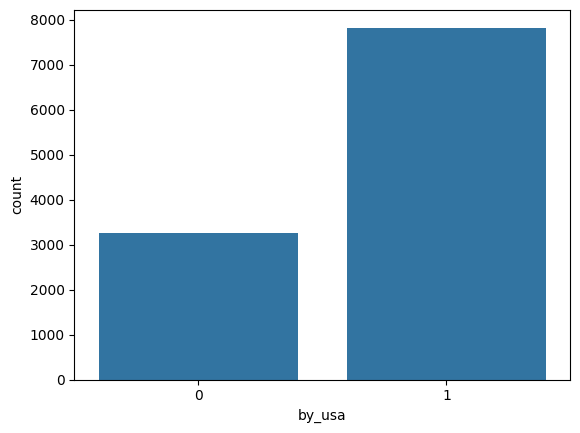

In [99]:
sns.countplot(
    x=df['by_usa']
)

In [ ]:
Sesgada, riesgo de overfittig. Luego vemos si se puede considerar o no. 

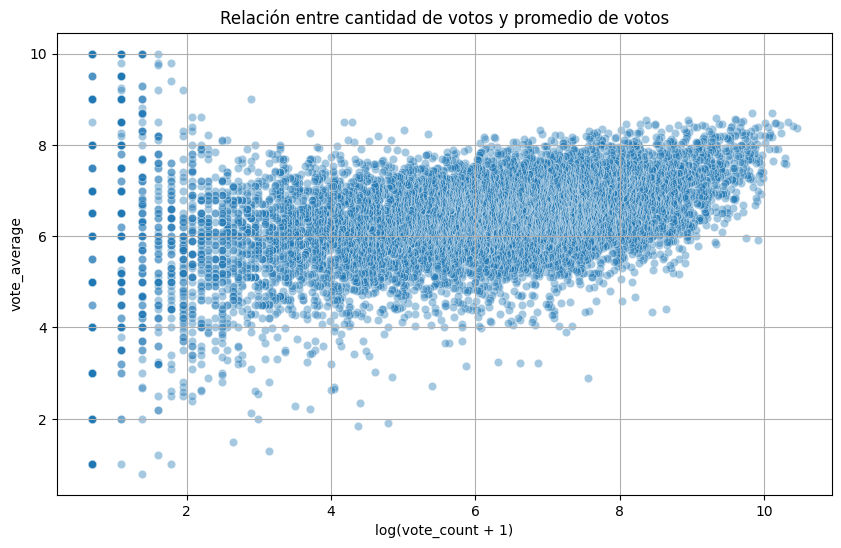

In [110]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=np.log1p(df['vote_count']),
    y=df["vote_average"],
    alpha=0.4
)

plt.xlabel("log(vote_count + 1)")
plt.ylabel("vote_average")
plt.title("Relación entre cantidad de votos y promedio de votos")
plt.grid(True)
plt.show()

Vemos que los valores con pocos votos tienen una gran variación de votos. Mientras mas cantidad de votos, el puntaje se estabiliza cerca de 6-7. 

In [ ]:
C = df["vote_average"].mean()
k = df["vote_count"].quantile(0.90)

#Promedio ponderado que usa imdb, asi evitamos las peliculas con 10 de puntuacion pero solo 1 voto.
df["weighted_score"] = (
    (df["vote_count"] / (df["vote_count"] + k)) * df["vote_average"] +
    (k / (df["vote_count"] + k)) * C
)

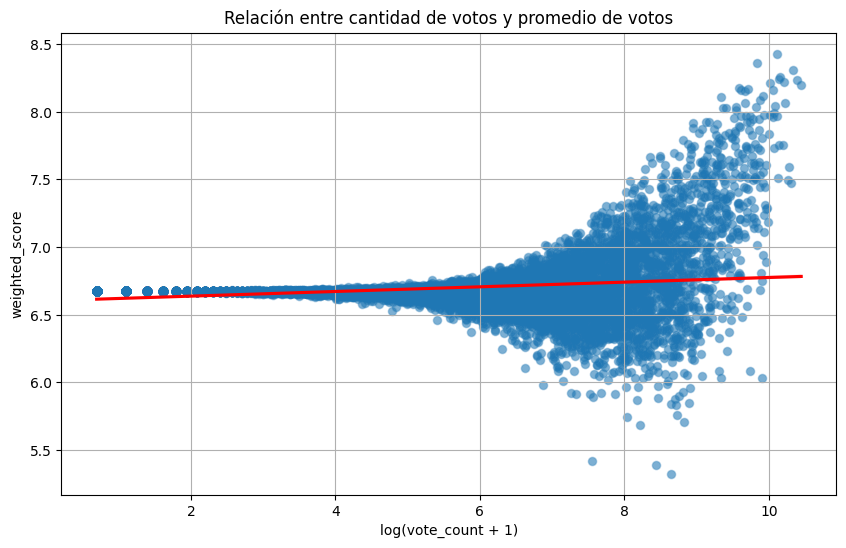

np.float64(0.2059380221812857)

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=np.log1p(df['vote_count']),
    y=df["weighted_score"],
    alpha=0.4
)

sns.regplot(
    data=df,
    x=np.log1p(df["vote_count"]),
    y="weighted_score",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)

plt.xlabel("log(vote_count + 1)")
plt.ylabel("weighted_score")
plt.title("Relación entre cantidad de votos y promedio de votos")
plt.grid(True)
plt.show()

np.corrcoef(np.log1p(df["vote_count"]), df["weighted_score"])[0, 1] # Se calcula con el logaritmo, porque la correlacion asume una relacion lineal

,revenue,weighted_score
revenue,1.00000,0.27271
weighted_score,0.27271,1.00000


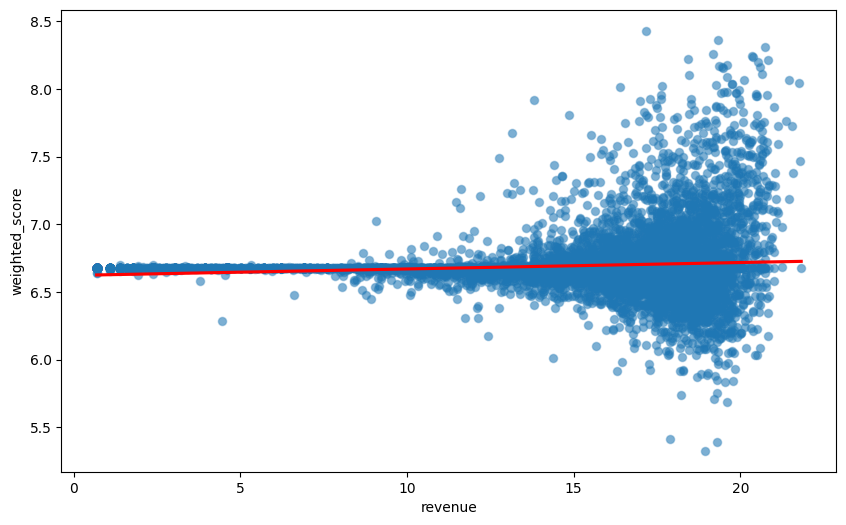

In [123]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=np.log1p(df['revenue']),
    y=df["weighted_score"],
    alpha=0.4
)

sns.regplot(
    data=df,
    x=np.log1p(df["revenue"]),
    y="weighted_score",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)

df[["revenue", "weighted_score"]].corr()

In [130]:
np.corrcoef(np.log1p(df["revenue"]), df["weighted_score"])[0, 1]

np.float64(0.09661042992867452)

np.float64(0.13949925854808978)

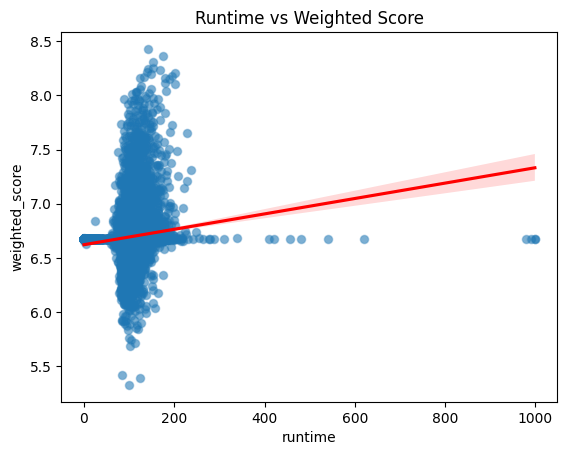

In [143]:
sns.scatterplot(
    data=df,
    x="runtime",
    y="weighted_score",
    alpha=0.4
)

sns.regplot(
    data=df,
    x="runtime",
    y="weighted_score",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)
plt.title("Runtime vs Weighted Score")
np.corrcoef(df["runtime"], df["weighted_score"])[0, 1]

np.float64(0.2059380221812857)

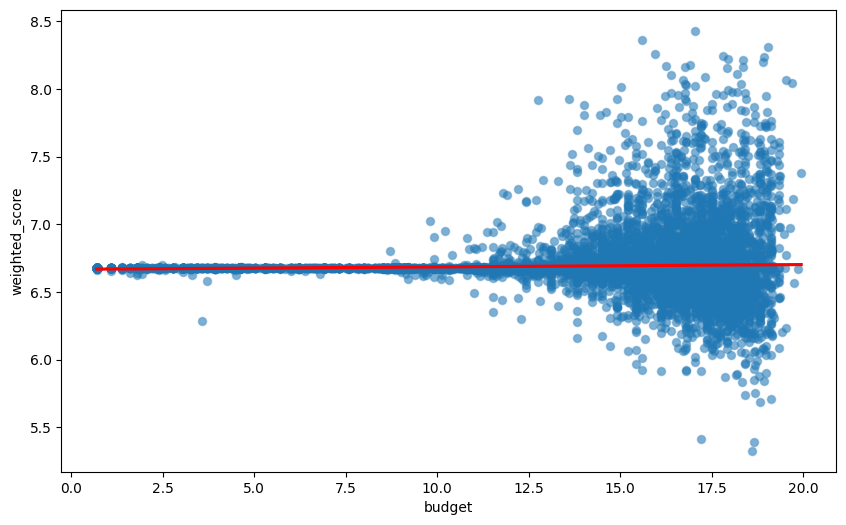

In [136]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=np.log1p(df['budget']),
    y=df["weighted_score"],
    alpha=0.4
)

sns.regplot(
    data=df,
    x=np.log1p(df["budget"]),
    y="weighted_score",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)

np.corrcoef(np.log1p(df["vote_count"]), df["weighted_score"])[0, 1]

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11083 entries, 0 to 11082
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    11083 non-null  int64   
 1   title                 11083 non-null  object  
 2   vote_average          11083 non-null  float64 
 3   vote_count            11083 non-null  int64   
 4   release_date          10832 non-null  object  
 5   revenue               11083 non-null  int64   
 6   runtime               11083 non-null  int64   
 7   adult                 11083 non-null  bool    
 8   budget                11083 non-null  int64   
 9   original_language     11083 non-null  object  
 10  overview              10655 non-null  object  
 11  popularity            11083 non-null  float64 
 12  genres                10845 non-null  object  
 13  production_companies  10264 non-null  object  
 14  production_countries  10390 non-null  object  
 15  ge

np.float64(0.1880870596658087)

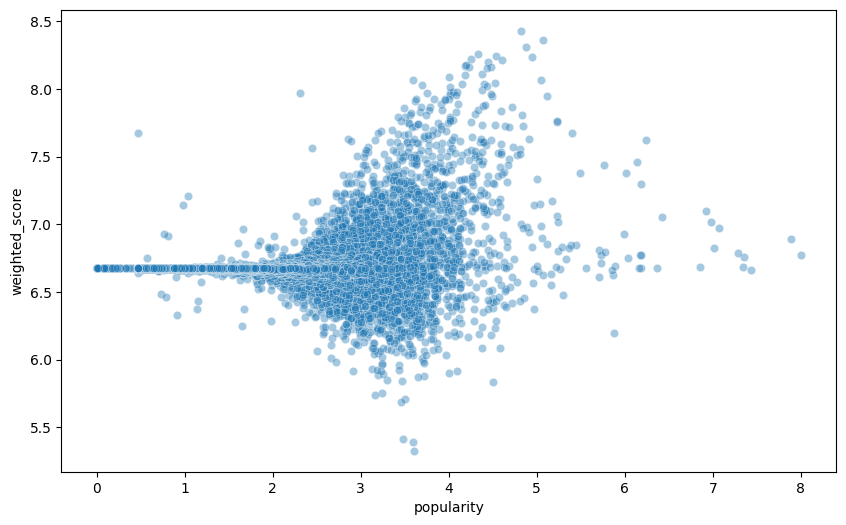

In [142]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=np.log1p(df['popularity']),
    y=df["weighted_score"],
    alpha=0.4
)



np.corrcoef(np.log1p(df["popularity"]), df["weighted_score"])[0, 1]

Las peliculas mas populares tienden a tener mejor puntuacion pero de forma debil moderada.

np.float64(0.1880870596658087)

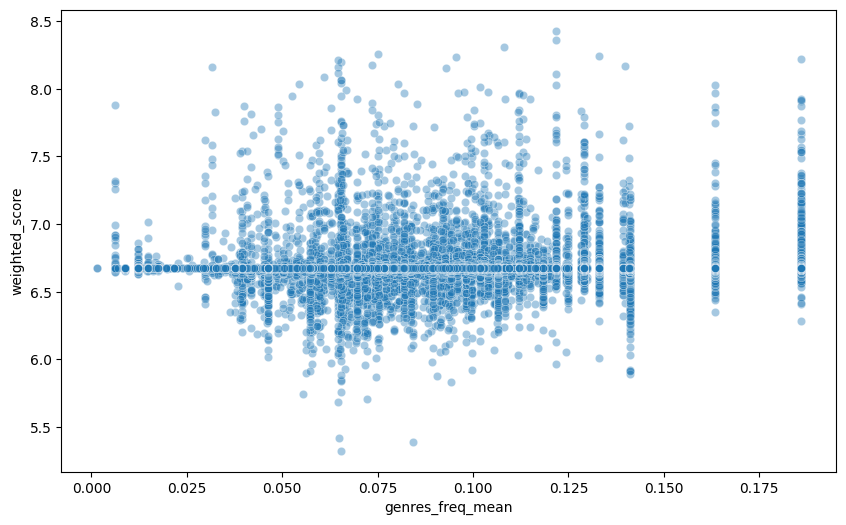

In [144]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=df["genres_freq_mean"],
    y=df["weighted_score"],
    alpha=0.4
)

np.corrcoef(np.log1p(df["popularity"]), df["weighted_score"])[0, 1]

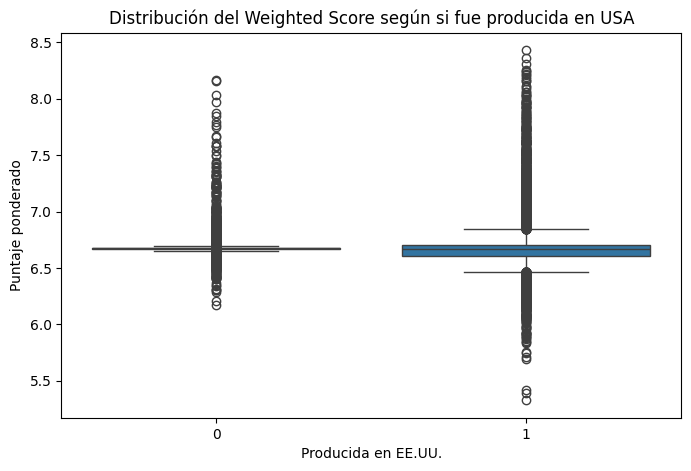

In [145]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="by_usa", y="weighted_score", data=df)
plt.title("Distribución del Weighted Score según si fue producida en USA")
plt.xlabel("Producida en EE.UU.")
plt.ylabel("Puntaje ponderado")
plt.show()

In [ ]:
df.groupby("by_usa")["weighted_score"].describe() # Aqui podemos observar que esta variable no afecta mucho en el score.

,count,mean,std,min,25%,50%,75%,max
by_usa,,,,,,,,
0,3257.0,6.695002,0.125111,6.171811,6.669445,6.675485,6.679856,8.167621
1,7826.0,6.691797,0.245059,5.327078,6.607425,6.670743,6.700770,8.429773


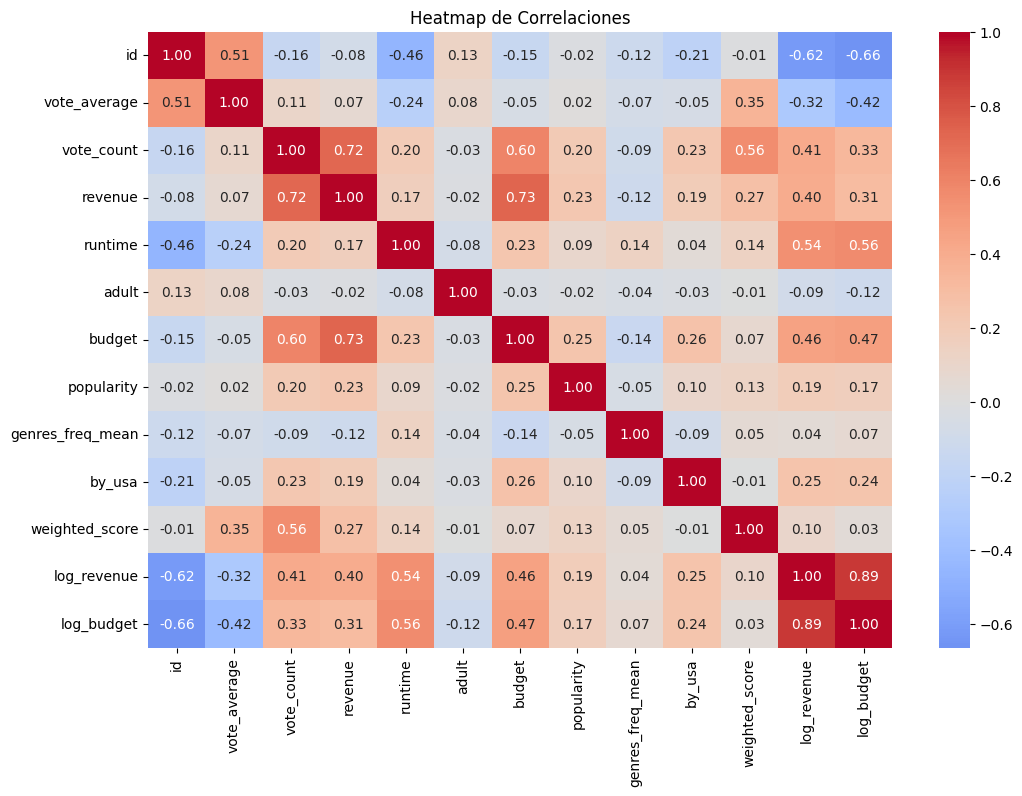

In [155]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Heatmap de Correlaciones")
plt.show()

In [154]:
df["log_revenue"] = np.log1p(df["revenue"])
df["log_budget"] = np.log1p(df["budget"])
df["log_revenue"] = np.log1p(df["revenue"])